# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
boston_df = pd.read_csv(url)

In [9]:
X = boston_df.drop('medv', axis=1)  # Признаки
y = boston_df['medv']

In [10]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [14]:
z = np.random.normal(loc=5, scale=3, size=10000)
(z ** 2).mean()

34.8027138896323

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [73]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    num_objects = X.shape[0]
    num_runs = min(num_runs, num_objects)

    predictions = {}
    for i in range(num_runs):
        choozed_idxs = np.random.choice(num_objects, size=num_objects, replace=True)
        regressor.fit(X.iloc[choozed_idxs], y.iloc[choozed_idxs])
        test_idxs = [i for i in range(num_objects) if i not in choozed_idxs]
        if (len(test_idxs) == 0):
            continue
        for idx in test_idxs:
            if idx not in predictions:
                predictions[idx] = []
            predictions[idx].append(regressor.predict(X.iloc[[idx]]))
    bias = np.mean([(np.mean(predictions[i]) - y[i]) ** 2 for i in predictions])
    variance = np.mean([np.var(prs) for prs in predictions.values()])
    error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())
    return bias, variance, error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [74]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
print(compute_biase_variance(model, X, y))

(23.724676439117836, 0.9683589704336364, 24.860192016225856)


C:\Users\annam\AppData\Local\Temp\ipykernel_32284\658412429.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())


In [75]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
print(compute_biase_variance(model, X, y))

(10.234320391456553, 13.085839153726521, 23.502578839474438)


C:\Users\annam\AppData\Local\Temp\ipykernel_32284\658412429.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())


In [79]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
print(compute_biase_variance(model, X, y))

(10.819084362445304, 2.24931457254395, 13.083171397027918)


C:\Users\annam\AppData\Local\Temp\ipykernel_32284\658412429.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

In [80]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression


model = BaggingRegressor(LinearRegression())
print(compute_biase_variance(model, X, y))

(23.674790776679664, 0.9750841189453858, 24.85186710597212)


C:\Users\annam\AppData\Local\Temp\ipykernel_32284\658412429.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())


In [81]:
model = BaggingRegressor(DecisionTreeRegressor())
print(compute_biase_variance(model, X, y))

(10.563651369113662, 3.3461101348299733, 13.973880920129288)


C:\Users\annam\AppData\Local\Temp\ipykernel_32284\658412429.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  error = np.sum([np.sum((np.array(pr) - y[i]) ** 2) for i, pr in predictions.items()]) / np.sum(len(pr) for pr in predictions.values())


In [82]:
model = BaggingRegressor(RandomForestRegressor())
print(compute_biase_variance(model, X, y))

KeyboardInterrupt: 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.
ф
__Your answer here:__

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [88]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    num_objects = X.shape[0]
    test_idxs = np.random.choice(num_objects, size=num_test_objects, replace=False)
    train_idxs = [i for i in range(num_objects) if i not in test_idxs]
    X_test, y_test = X.iloc[test_idxs], y.iloc[test_idxs]
    X_train, y_train = X.iloc[train_idxs], y.iloc[train_idxs]
    for i in range(num_runs):
        choozed_idxs = np.random.choice(len(X_train), size=len(X_train), replace=True)
        regressor.fit(X_train.iloc[choozed_idxs], y_train.iloc[choozed_idxs])
        plt.scatter(np.arange(num_test_objects), regressor.predict(X_test), color='blue')
    plt.scatter(np.arange(num_test_objects), y_test, color = 'black')
    plt.x_label = 'testing object'
    plt.y_label = 'predictions'
    plt.title(title)

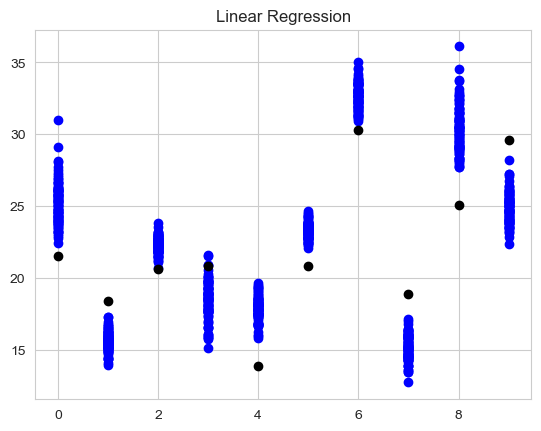

In [89]:
plot_predictions(LinearRegression(), X, y, title="Linear Regression")

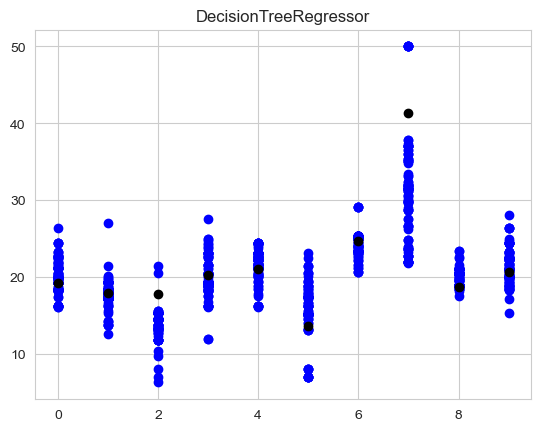

In [90]:
plot_predictions(DecisionTreeRegressor(), X, y, title="DecisionTreeRegressor")

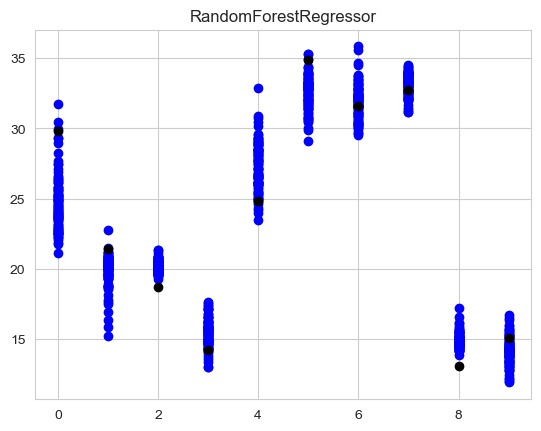

In [91]:
plot_predictions(RandomForestRegressor(), X, y, title="RandomForestRegressor")

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

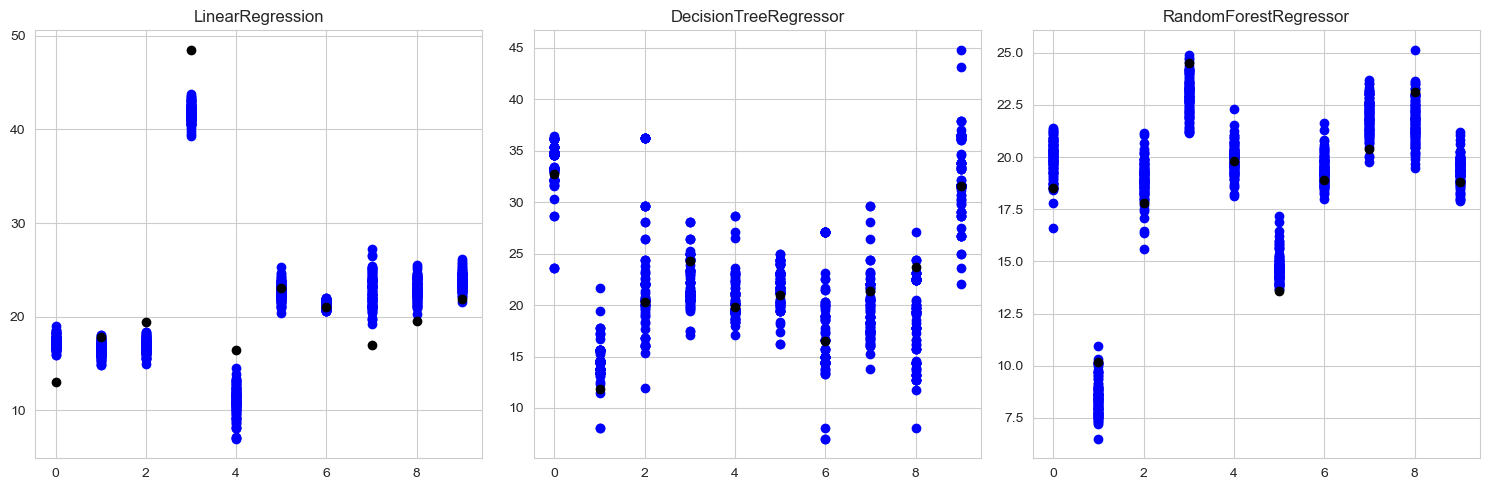

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # 1 строка, 3 столбца

# Задаем текущую ось для каждого графика
plt.sca(ax1)  # Устанавливаем первую ось как текущую
plot_predictions(LinearRegression(), X, y, title="LinearRegression")

plt.sca(ax2)  # Устанавливаем вторую ось как текущую
plot_predictions(DecisionTreeRegressor(), X, y, title="DecisionTreeRegressor")

plt.sca(ax3)  # Устанавливаем третью ось как текущую
plot_predictions(RandomForestRegressor(), X, y, title="RandomForestRegressor")

plt.tight_layout()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [101]:
depth_vars = np.arange(1, 11)
max_features_vars = np.arange(3, X.shape[1])

fig, axes = plt.subplots(len(depth_vars), len(max_features_vars), figsize=(12 * 8, 10 * 8))

for i, max_depth in enumerate(depth_vars):
    for j, max_features in enumerate(max_features_vars):
        plt.sca(axes[i, j])
        plot_predictions(DecisionTreeRegressor(max_depth=max_depth, max_features=max_features), X, y, title="max_depth=%d, max_features=%d" % (max_depth, max_features), num_test_objects=5)

plt.tight_layout()
plt.show()

теперь по отдельности потому что это не читаемо

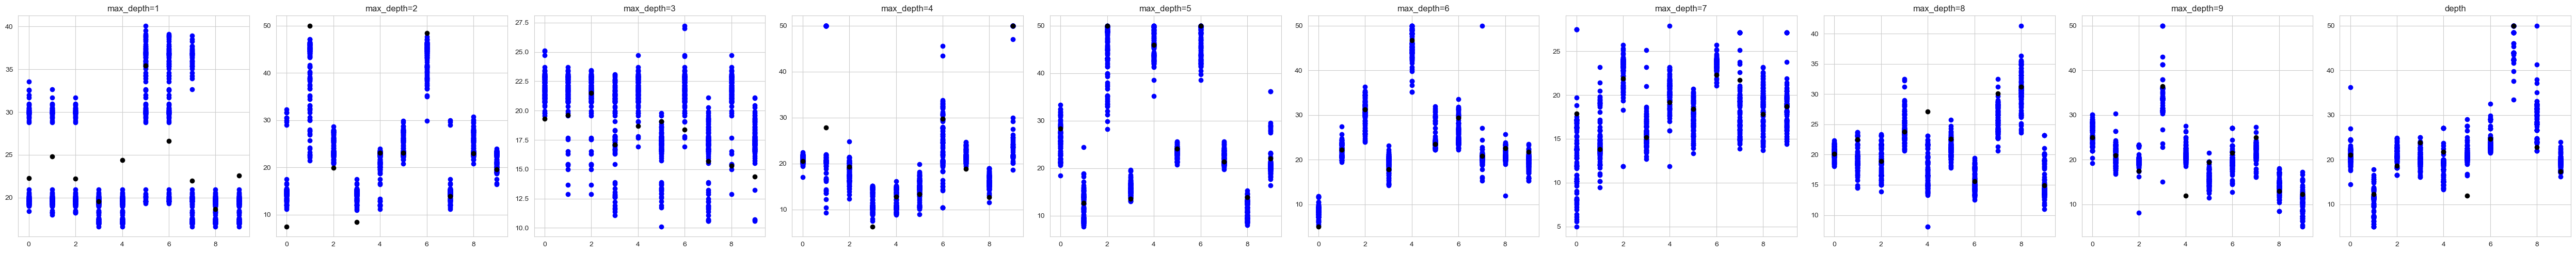

In [103]:
depth_vars = np.arange(1, 11)

fig, axes = plt.subplots(1, len(depth_vars), figsize=(10 * 5, 5))

for i, max_depth in enumerate(depth_vars):
    plt.sca(axes[i])
    plot_predictions(DecisionTreeRegressor(max_depth=max_depth), X, y, title="max_depth=%d" % max_depth)

plt.tight_layout()
plt.title("depth")
plt.show()

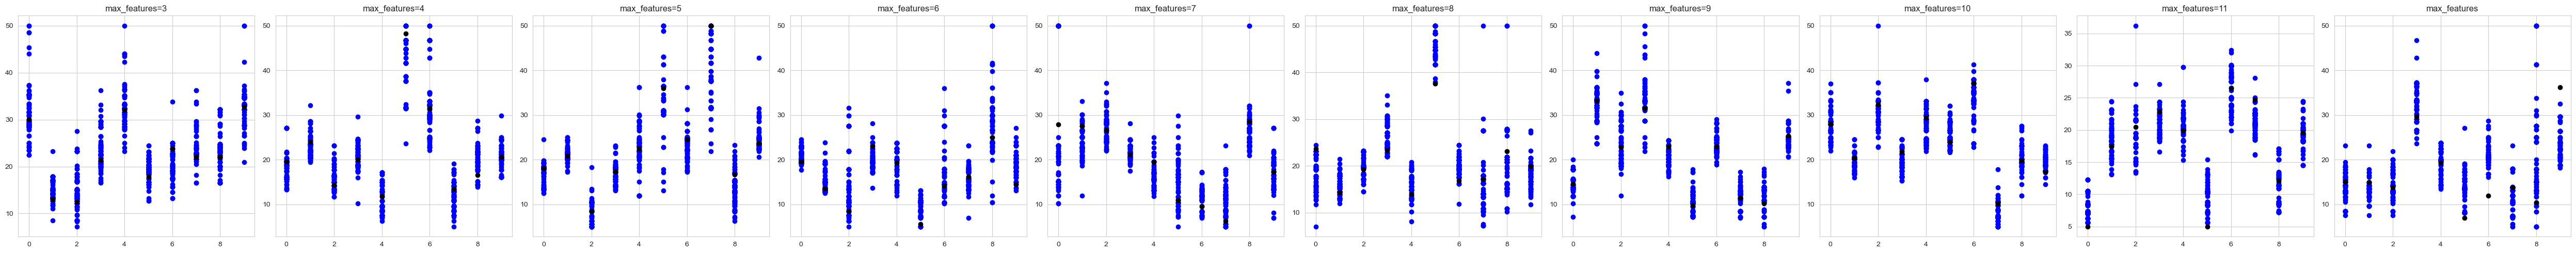

In [104]:
max_features_vars = np.arange(3, X.shape[1])

fig, axes = plt.subplots(1, len(max_features_vars), figsize=(10 * 5, 5))

for i, max_features in enumerate(max_features_vars):
    plt.sca(axes[i])
    plot_predictions(DecisionTreeRegressor(max_features=max_features), X, y, title="max_features=%d" % max_features)

plt.tight_layout()
plt.title("max_features")
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

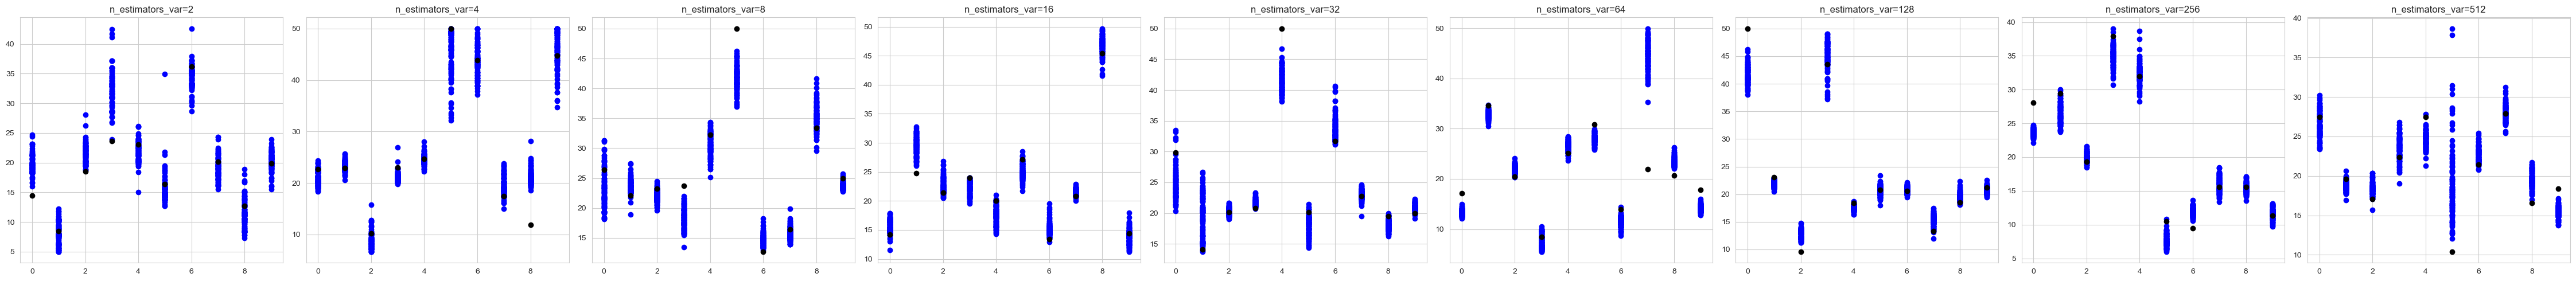

In [102]:
n_estimators_var = 2 ** np.arange(1, 10)

fig, axes = plt.subplots(1, len(n_estimators_var), figsize=(len(n_estimators_var) * 5, 5))

for i, n_estimators in enumerate(n_estimators_var):
    plt.sca(axes[i])
    plot_predictions(RandomForestRegressor(n_estimators=n_estimators), X, y, title="n_estimators_var=%d" % n_estimators)

plt.tight_layout()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__